In [30]:
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sympy.printing.pretty.pretty_symbology import line_width


#from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [31]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', '..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'
# log_dir = PATH('')

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

EPOCHS = 30
ALPHA = 0.1

TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 100 # number of epochs
ALPHA = 0.0003 # learning rate
BATCH_SIZE = 64 # mini batch size (number of rows)
TEST_SIZE = 0.2 # test size for train-test split
TRAIN_SIZE=int(18 *BATCH_SIZE)
WEIGHT_DECAY=0.001 # ADAMW
PATIENCE=20 # for Early Stopping
LR_FACTOR =0.1#Reduction on LR Factor
LR_PATIENCE=3 # how long should i wait
MIN_LR = 1e-6#min
# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [32]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


In [33]:
def fn_plot_tf_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [34]:
data_df=pd.read_csv('household_power_consumption.txt',sep=';',na_values=['nan','?'])    #is there ? convert to 'nan'
data_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [35]:
data_df['dt']=pd.to_datetime(data_df['Date']+' '+data_df['Time'],dayfirst=True)
data_df=data_df.set_index('dt',drop=True)
data_df=data_df.drop(['Date','Time'],axis=1)
data_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [36]:
data_df=data_df.fillna(data_df.mean())
df_resample=data_df.resample('h').mean()
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [37]:
df_resample['target']=df_resample['Global_active_power'].shift(-1)
df_resample=df_resample.dropna()
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,target
dt,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,3.632200
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,3.400233
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,3.268567
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,3.056467
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,2.200133


In [38]:
split=365*24
train_df=df_resample.iloc[:split]
test_df=df_resample.iloc[split:]
df_resample.shape,train_df.shape,test_df.shape

((34588, 8), (8760, 8), (25828, 8))

In [39]:
y_train=train_df['target'].to_numpy()
y_test=test_df['target'].to_numpy()

train_feat_df=train_df.drop('target',axis=1)
test_feat_df=test_df.drop('target',axis=1)

train_feat_df.shape,test_feat_df.shape

((8760, 7), (25828, 7))

In [40]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(train_feat_df)
X_test=scaler.transform(test_feat_df)
X_train.shape,X_test.shape

((8760, 7), (25828, 7))

In [41]:
#converting Xdatas to _> batch x timestamps x feature
X_train=X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test=X_test.reshape(X_test.shape[0],1,X_test.shape[1])
X_train.shape,X_test.shape

((8760, 1, 7), (25828, 1, 7))

In [42]:
model = tf.keras.Sequential()
init=tf.keras.initializers.HeNormal()
model.add(tf.keras.Input(shape=(X_train.shape[1],X_train.shape[2])))
model.add(tf.keras.layers.LSTM(units=512, activation='tanh',kernel_initializer=init))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [43]:
optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA)
loss_fn=tf.keras.losses.MeanSquaredError()
metrics=tf.keras.metrics.RootMeanSquaredError()

In [44]:

#call backs:
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir = 'logDir'
)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = PATIENCE,
    verbose = 1,
    restore_best_weights =True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = LR_FACTOR,
    patience = LR_PATIENCE,
    verbose = 1,
    mode = 'auto',
    min_lr = MIN_LR,
)

In [45]:
model.compile(optimizer = optimizer, loss = loss_fn, metrics = [metrics])

In [46]:
history = model.fit(X_train,y_train,
                    validation_data=[X_test,y_test],
                    callbacks = [es_callback,lr_callback],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.6290 - root_mean_squared_error: 0.7931 - val_loss: 0.3636 - val_root_mean_squared_error: 0.6030 - learning_rate: 3.0000e-04
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.4575 - root_mean_squared_error: 0.6764 - val_loss: 0.3528 - val_root_mean_squared_error: 0.5939 - learning_rate: 3.0000e-04
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.4466 - root_mean_squared_error: 0.6683 - val_loss: 0.3506 - val_root_mean_squared_error: 0.5921 - learning_rate: 3.0000e-04
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.4500 - root_mean_squared_error: 0.6708 - val_loss: 0.3497 - val_root_mean_squared_error: 0.5914 - learning_rate: 3.0000e-04
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.4448 - root_mean_squared_error: 0.6670 - val_loss: 0.3478 - val_root_mean_squared_error: 0.5898 - learning_rate: 3.0000e-04
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss

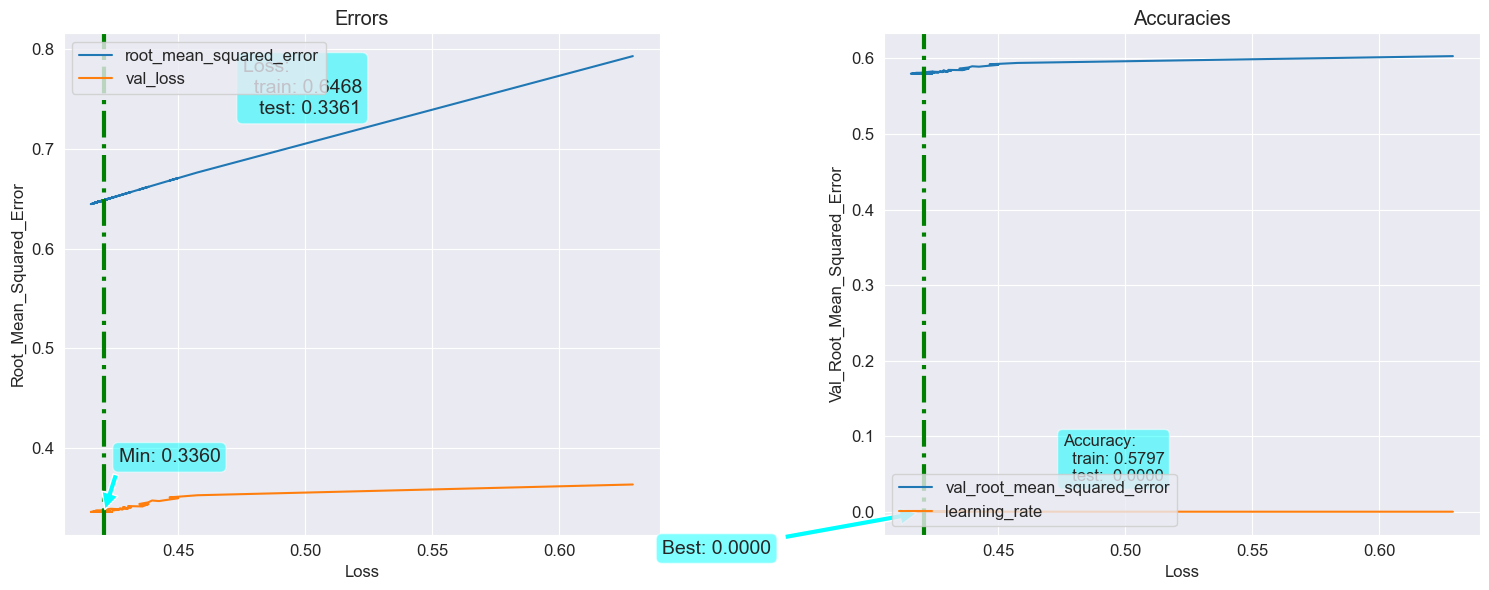

In [47]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)